<a href="https://colab.research.google.com/github/AchrafAsh/gnn-receptive-fields/blob/main/06_khop_with_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

After some reflection (and seeing that our model had way too many parameters), we realised something weird happening in the design of Graph Neural Networks.
Most GNNs, if not all, are embedding the input features in the first layer which has a receptive field containing only the direct neighbors.
It leads to a very biased embedding (100% attention from the direct neighbors) which could potentially cause a loss of information that is irrelevant for the direct neighbors, but highly relevant for remote ones or even for the task at hand.

Because our approach required to compute new embeddings for each k-hop neighborhood, we realised that this was not an ideal way of computing embeddings.

In this notebook, we try to design a new Message Passing GNN with an initial MLP that serves as an embedding layer from which we then operate our different convolutional layers.

## **🚀 Setting up the environment**

In [1]:
import os, sys
import os.path as osp
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
try:
    os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
except:
    pass
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [2]:
# import everything
import math
import random
import copy
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import networkx as nx
import yaml

from functools import partial
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from torch_geometric.utils import degree, to_dense_adj, dense_to_sparse, add_self_loops, to_networkx
from torch_geometric.nn import GCNConv, MessagePassing, Sequential
from torch_sparse import spmm, spspmm
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
sns.set_style('darkgrid')

In [3]:
%%capture
!wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/data.py
!wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/utils.py

from data import load_dataset
from utils import save_experiment

## **🎨 Designing the model**

In [4]:
# Parameter initialization
def xavier(tensor):
    if tensor is not None:
        stdv = math.sqrt(6.0 / (tensor.size(-2) + tensor.size(-2)))
        tensor.data.uniform_(-stdv, stdv)


def zeros(tensor):
    if tensor is not None:
        tensor.data.fill_(0)

#### **Our version of the GCNConv**

In [5]:
class OurGCNConv(MessagePassing):
    def __init__(self, num_features:int, in_channels:int, out_channels:int, k:int):
        super().__init__(aggr='add')  # "Add" aggregation
        self.k = k
        self.lin_neb = torch.nn.Linear(num_features, out_channels)
        self.lin_trgt = torch.nn.Linear(in_channels, out_channels)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        xavier(self.lin_neb.weight)
        zeros(self.lin_neb.bias)
        
        xavier(self.lin_trgt.weight)
        zeros(self.lin_trgt.bias)

    def forward(self, x, h, edge_index):
        # x is the input features and has shape [N, num_features]
        # h is the hidden state and has shape [N, in_channels]
        # edge_index has shape [2, E] , E being the number of edges

        # step 1: linearly transform node feature matrices
        x = self.lin_neb(x)
        h = self.lin_trgt(h)

        # step 3-5: start propagating messages
        return self.propagate(edge_index[self.k].to(device), x=x, h=h)

    def message(self, x_j, h_i, edge_index, size):
        # x_j is the input features of the neighbors and has shape [E, out_channels] (has already been multiplied by the weight matrix)

        # step 3: normalize node features
        row, col = edge_index
        deg = degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        out = norm.view(-1, 1) * x_j

        return out + h_i

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels] is the output of self.message()

        # step 5: return new node embeddings
        return aggr_out

#### **Our full model architecture**

In [35]:
# the real deal
class OurModel(torch.nn.Module):
    def __init__(self, num_layers:int, hidden_dim:int, num_features:int, 
                 num_classes:int, propagation_steps:int=2, dropout:float=0.5):
        super().__init__()
        self.propagation_steps = propagation_steps
        
        self.alpha = torch.nn.Parameter(torch.tensor(0.5), requires_grad=True)
        # Embedding input features
        self.in_mlp = torch.nn.Sequential(
            torch.nn.Linear(in_features=num_features, out_features=hidden_dim),
            torch.nn.ReLU()
        )
        # Convolutional layers
        self.conv_layers = self.create_layers(num_layers=num_layers,
                                              hidden_dim=hidden_dim,
                                              dropout=dropout)
        # Readout function
        self.readout = torch.nn.Sequential(
            torch.nn.Linear(in_features=hidden_dim, out_features=num_classes),
            torch.nn.LogSoftmax(dim=1)
        )

    def create_layers(self, num_layers:int, hidden_dim:int, dropout:float):
        layers = [(OurGCNConv(num_features=hidden_dim, in_channels=hidden_dim, out_channels=hidden_dim, k=0), "x, x, edge_index -> h"),
                (torch.nn.ReLU(inplace=True)),
                (torch.nn.Dropout(p=dropout), "h -> h")]
        
        for k in range(1, num_layers):
            layers += [
                (OurGCNConv(num_features=hidden_dim, in_channels=hidden_dim, out_channels=hidden_dim, k=k), "x, h, edge_index -> h"),
                # (GCNConv(hidden_dim, hidden_dim), "h, edge_index -> h"),
                (torch.nn.ReLU(inplace=True)),
                (torch.nn.Dropout(p=dropout), "h -> h")
            ]
        return Sequential("x, edge_index", layers)


    def reset_parameters(self):
        self.conv_layers.reset_parameters()


    def propagate(self, x, edge_index):
        # add self loops
        # edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        # normalize
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        
        dense_adj = to_dense_adj(edge_index).squeeze(0)
        edge_index_pow = torch.eye(G.num_nodes).to(device)
        prop_repr = edge_index_pow.clone()

        for _ in range(self.propagation_steps):
            edge_index_pow = torch.mm(dense_adj, edge_index_pow)
            prop_repr += edge_index_pow
        return torch.mm(prop_repr, x)
        
        # APPNP propagation scheme
        # z = spmm(edge_index, norm, x.size(0), x.size(0), z) * (1-self.alpha) + x * self.alpha

        # another propagation scheme (sum of the powers of A)
        # props = []
        # for _ in range(self.propagation_steps):
        #     x= spmm(edge_index, norm, x.size(0), x.size(0), x)
        #     props.append(x)
        # return sum(props)


    def forward(self, x, edge_index):
        embeddings = self.in_mlp(x)
        h = self.conv_layers(embeddings, edge_index)
        out = self.propagate(h, edge_index[0].to(device))
        return h, self.readout(out)

## **🧰 Utility functions**

In [7]:
def get_k_neighbors(k: int):
    """Returns the l-hop neighbors for l between 1 (the adjacency matrix) and k (given depth)

    Args:
        - k (int): size of the maximum neighborhood
    """
    
    output = [G.edge_index]
    dense_adj = to_dense_adj(G.edge_index).squeeze(0)
    dense_nebs = [dense_adj.clone()]
    adj_pow = dense_adj.clone()

    for l in tqdm(range(1, k)):
        adj_pow = torch.mm(dense_adj, adj_pow)
        k_neb = torch.where(
            torch.where(adj_pow > 0, 1, 0) - sum(dense_nebs) > 0,
            1,
            0
        )
        dense_nebs.append(k_neb)
        output.append(dense_to_sparse(k_neb)[0])
    
    return output

In [8]:
def tsne_plot(model: torch.nn.Module, all_edge_index:list, title:str):
    # Representing the representations with t-SNE algorithm
    h, logits = model(G.x, all_edge_index)
    representations = TSNE().fit_transform(h.cpu().detach().numpy())
    
    # Plot the 2-D representations, both with true labels and predictions
    fig, ax = plt.subplots(1, 2, figsize=(24, 8))
    fig.suptitle(title, fontsize=20)

    sns.scatterplot(x=representations[:,0], y=representations[:,1], hue=logits.cpu().detach().argmax(dim=1), legend='full', palette=palette, ax=ax[0]).set(title="Predictions")
    sns.scatterplot(x=representations[:,0], y=representations[:,1], hue=G.y.cpu().detach().numpy(), legend='full', palette=palette, ax=ax[1]).set(title="True labels")
    
    fig.show()
    return representations

In [9]:
# count model parameters
def count_parameters(model: torch.nn.Module):
    total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"The model has {total_parameters:,} parameters")

    return total_parameters

In [10]:
def make(config):
    # Make the model
    model = OurModel(num_layers=config['num_layers'],
                     hidden_dim=config['hidden_dim'],
                     num_features=cora_dataset.num_features,
                     num_classes=cora_dataset.num_classes,
                     propagation_steps=config['propagation_steps'],
                     dropout=config['dropout']).to(device)

    # Make the loss and optimizer
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config['learning_rate'],
                                 weight_decay=config['weight_decay'])
    
    return model, criterion, optimizer

In [11]:
def train(model, all_edge_index, criterion, optimizer, config):
    dense_adj = to_dense_adj(G.edge_index).squeeze(0)

    outputs = []
    
    for _ in range(config['runs']):
        for epoch in tqdm(range(config['epochs'])):
            loss = train_step(model, all_edge_index, optimizer, criterion)
            
            # test the model
            outs = test(model, all_edge_index, criterion, 
                        metrics=[('mad', mad_value),
                                ('mad_gap', partial(mad_gap_value,dense_adj)),
                                ('mad_sp', shortest_path_mad)])
            outs['epoch'] = epoch
            outputs.append(outs)

    return pd.DataFrame(outputs)

In [12]:
def train_step(model, all_edge_index, optimizer, criterion):
    """Performs one training step
    """
    model.train()
    
    # Forward pass
    _, out = model(G.x.to(device), all_edge_index)
    loss = criterion(out[G.train_mask], G.y[G.train_mask])
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [13]:
def test(model, all_edge_index, criterion, metrics=[]):
    """
    Metrics is a list of tuple ('metric_name', metric_func) where the metric 
    function takes the last representation matrix and returns a scalar.
    """

    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        h, logits = model(G.x, all_edge_index)

    outs = {}
    h = h.detach().cpu()
    for (name, metric) in metrics:
        outs[name] = metric(h)

    for key in ['train', 'val', 'test']:
        mask = G[f'{key}_mask']
        loss = criterion(logits[mask], G.y[mask]).item()
        pred = logits[mask].max(1)[1]
        acc = pred.eq(G.y[mask]).sum().item() / mask.sum().item()

        outs[f'{key}_loss'] = loss
        outs[f'{key}_acc'] = acc
    
    return outs

In [14]:
def model_pipeline(config):
    # create the model
    model, criterion, optimizer = make(config)
    config['total_parameters'] = count_parameters(model)
    
    # compute different depth edge_index
    all_edge_index = get_k_neighbors(config['num_layers'])

    # train the model
    logs = train(model, all_edge_index, criterion, optimizer, config)

    # repr = tsne_plot(model, all_edge_index, title="Last hidden representations")

    return model, logs, config

#### Import Cora

In [15]:
%%capture
path = osp.join(os.getcwd(), 'data')
cora_dataset = load_dataset(path, 'Cora')
G = cora_dataset[0].to(device) # only graph of the dataset
palette = sns.color_palette("hls", cora_dataset.num_classes)

#### Over-smoothing metrics

In [16]:
def mad_value(in_arr, mask_arr=None, distance_metric='cosine', digt_num=4, target_idx=None):
    """The numpy version for mad (able to compute quickly)

    Args:
        - in_arr [num_nodes, hidden_dim]: the node feature matrix
        - mask_arr [num_nodes, num_nodes]: the mask matrix of the target relations (is it the adjacency matrix?)
        - target_idx [1, 2, 3, ...n]: the nodes indices for which we calculate the mad value
    """

    if mask_arr == None:
        mask_arr = torch.ones(in_arr.size(0), in_arr.size(0))

    dist_arr = pairwise_distances(in_arr, in_arr, metric=distance_metric)
    mask_dist = np.multiply(dist_arr, mask_arr.detach().cpu())
    divide_arr = (mask_dist != 0).sum(1) + 1e-8
    
    node_dist = mask_dist.sum(1) / divide_arr
    if target_idx==None:
        mad = node_dist.mean()
    else:
        node_dist = np.multiply(node_dist,target_idx)
        mad = node_dist.sum()/((node_dist!=0).sum()+1e-8)

    try:
        mad = round(mad, digt_num)
    except:
        pass

    return mad

In [17]:
def mad_gap_value(adj, in_arr):
    """Simple version of the MADGap metric implementation

    Args:
        - in_arr [node_num, hidden_dim]: the node feature matrix
        - adj [node_num, node_num]: dense adjacency matrix
    """

    mad_neb = mad_value(in_arr=in_arr, mask_arr=adj)
    mad_rmt = mad_value(in_arr=in_arr, mask_arr=1-adj)

    return (mad_rmt - mad_neb).item()

In [18]:
def get_shortest_path_lengths():
    g = to_networkx(G)
    shortest_paths = nx.shortest_path_length(g)

    sp_matrix = torch.zeros((G.num_nodes, G.num_nodes), dtype=int)

    for node_idx, path_lengths in shortest_paths:
        for (idx, len) in path_lengths.items():
            sp_matrix[node_idx, idx] = len
    
    return sp_matrix

In [19]:
shortest_path_lens = get_shortest_path_lengths()
shortest_path_mask = torch.where(shortest_path_lens == 0, torch.tensor(0, dtype=torch.float32), 1/shortest_path_lens)

In [20]:
def shortest_path_mad(in_arr):
    """Computes MAD of all node with shortest path normalization

    Args:
        - h [num_nodes, num_nodes]: representation matrix
    """
    
    return mad_value(in_arr=in_arr,
                     mask_arr=shortest_path_mask)

## **🧪 Run experiments**

#### Run pipeline

In [36]:
config = dict(
    num_layers=2,
    hidden_dim=16,
    propagation_steps=10,
    learning_rate=0.001,
    weight_decay=1e-5,
    dropout=0.5,
    epochs=200,
    runs=5)

In [37]:
model, logs, config = model_pipeline(config)

The model has 24,152 parameters


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [38]:
save_experiment('/content/2-ourgcn-sum-propagation/', model, logs, config, "Use the new propagation scheme: I + A + A^2 + A^3 + ...")

Done


In [47]:
!zip -r 2-ourgcn-sum-propagation.zip /content/2-ourgcn-sum-propagation/

  adding: content/2-ourgcn-sum-propagation/ (stored 0%)
  adding: content/2-ourgcn-sum-propagation/config.yml (deflated 20%)
  adding: content/2-ourgcn-sum-propagation/model.pt (deflated 11%)
  adding: content/2-ourgcn-sum-propagation/comment.txt (deflated 11%)
  adding: content/2-ourgcn-sum-propagation/logs.csv (deflated 68%)


In [53]:
def plot_results(data:pd.DataFrame):
    _, ax = plt.subplots(1, 2, figsize=(24,12))
    sns.lineplot(ax=ax[0], x='epoch', y='value', hue='variable',
                data=pd.melt(data[['epoch', 'train_acc', 'test_acc', 'val_acc']], ['epoch'])).set(xlabel="depth", ylabel="acc", title="Homophily")
    sns.lineplot(ax=ax[1], x='epoch', y='value', hue='variable',
                 data=pd.melt(data[['epoch', 'train_loss', 'test_loss', 'val_loss']], ['epoch'])).set(xlabel="depth", ylabel="loss", title="Correlation")

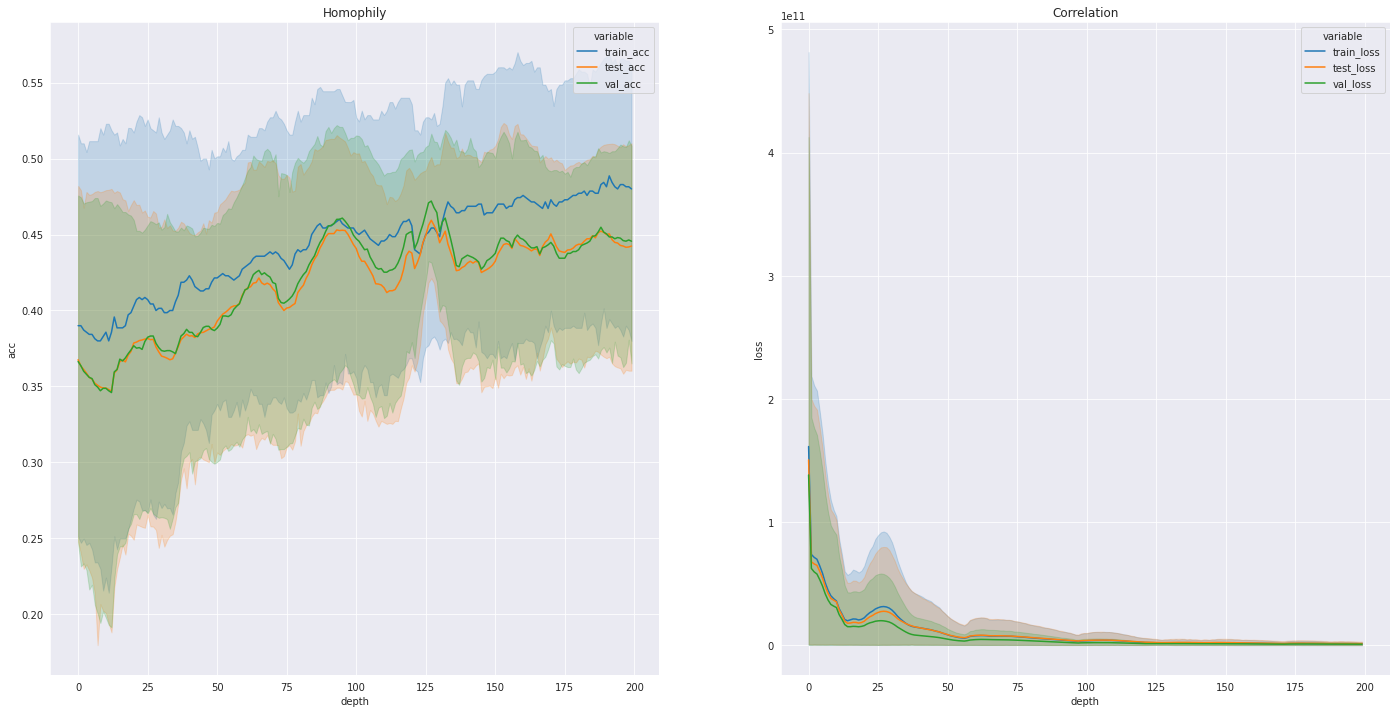

In [54]:
plot_results(logs)